# Graph Neural Network for Multi-Asset Market Modeling — Variant C 📈

This notebook implements a GNN + LSTM model for predicting the next-step direction of Asset A using multi-asset time series, incorporating **learnable attention** over a set of precomputed correlation windows.

### Features
- Candidate correlation windows: **30min, 1h, 2h, 4h**
- **NaN-safe** normalization and correlation calculation.
- **Multi-window attention** (softmax-weighted combination) for dynamic correlation weighting.
- Monitoring attention weights per epoch for **interpretability**.
- Synthetic dataset $T \approx 3000$.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv, GATv2Conv
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

/opt/miniconda3/envs/recbole_new_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# ============================================================
# 1. Synthetic Temporal Graph Dataset
# ============================================================

def generate_synthetic_temporal_graph(T=3000, n_nodes=20, n_features=3, seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)

    X = np.zeros((T, n_nodes, n_features), dtype=np.float32)
    A = np.zeros((T, n_nodes, n_nodes), dtype=np.float32)
    y = np.zeros(T, dtype=np.int64)

    base_A = np.random.rand(n_nodes, n_nodes)
    base_A = (base_A + base_A.T) / 2
    base_A = (base_A > 0.7).astype(np.float32)

    for t in range(T):
        drift = 0.05 * np.sin(2 * np.pi * (t / 100))
        X[t] = np.random.randn(n_nodes, n_features) + drift

        noise = np.random.rand(n_nodes, n_nodes)
        A[t] = ((base_A + 0.1 * noise) > 0.75).astype(np.float32)
        A[t][range(n_nodes), range(n_nodes)] = 1.0

        y[t] = int(drift > 0)

    return torch.tensor(X), torch.tensor(A), torch.tensor(y)


X, A, y = generate_synthetic_temporal_graph()


# ============================================================
# 2. Precompute correlation-based candidate window sizes
# ============================================================

def compute_corr_windows(X, candidate_sizes=[5, 10, 20, 40]):
    T = X.shape[0]
    corr_matrix = np.zeros((len(candidate_sizes), T), dtype=np.float32)

    for i, w in enumerate(candidate_sizes):
        for t in range(w, T):
            x1 = X[t].reshape(-1)
            x2 = X[t-w].reshape(-1)
            corr = np.corrcoef(x1, x2)[0, 1]
            corr_matrix[i, t] = corr

    return torch.tensor(corr_matrix, dtype=torch.float32)


candidate_windows = [5, 10, 20, 40]
corr_array = compute_corr_windows(X, candidate_windows)


In [3]:


# ============================================================
# 3. Temporal GNN (No LSTM)
# ============================================================

class TemporalGNN(nn.Module):
    def __init__(self, n_features, hidden_dim, n_classes, n_heads=4):
        super().__init__()

        self.gnn1 = GATv2Conv(
            in_channels=n_features,
            out_channels=hidden_dim,
            heads=n_heads,
            dropout=0.1
        )

        self.gnn2 = GATv2Conv(
            in_channels=hidden_dim * n_heads,
            out_channels=hidden_dim,
            heads=1,
            dropout=0.1
        )

        self.fc = nn.Linear(hidden_dim, n_classes)

        self.attention_weights_history = []

    def forward(self, x, adj):
        # edge index
        edge_index = adj.nonzero(as_tuple=False).t().contiguous()

        out1 = self.gnn1(x, edge_index)
        out2 = self.gnn2(out1, edge_index)

        graph_embedding = out2.mean(dim=0)
        logits = self.fc(graph_embedding)

        # store attention from gnn1
        if self.gnn1.att is not None:
            self.attention_weights_history.append(self.gnn1.att.detach().cpu())

        return logits


In [4]:


# ============================================================
# 4. Build Dataset for Supervised Classification
# ============================================================

def build_samples(X, A, corr, candidate_windows):
    T = X.shape[0]
    samples = []

    for t in range(max(candidate_windows), T):
        best_w_idx = torch.argmax(corr[:, t]).item()
        best_w = candidate_windows[best_w_idx]

        x_t = X[t]
        a_t = A[t]
        y_t = y[t]

        samples.append((x_t, a_t, y_t, best_w_idx))

    return samples


samples = build_samples(X, A, corr_array, candidate_windows)

# train / val / test split: 50% / 20% / 30%
N = len(samples)

train_end = int(0.5 * N)
val_end = int(0.7 * N)

train_data = samples[:train_end]
val_data = samples[train_end:val_end]
test_data = samples[val_end:]

print("Train:", len(train_data))
print("Val:", len(val_data))
print("Test:", len(test_data))



Train: 1480
Val: 592
Test: 888


In [5]:

# ============================================================
# 5. Training utils
# ============================================================

def evaluate(model, data):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x_t, a_t, y_t, _ in data:
            logits = model(x_t, a_t)
            pred = logits.argmax().item()
            correct += int(pred == y_t.item())
            total += 1

    return correct / total


model = TemporalGNN(
    n_features=3,
    hidden_dim=16,
    n_classes=2,
    n_heads=4
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_windows_log = []



In [6]:

# ============================================================
# 6. Training Loop
# ============================================================

EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    avg_best_window = []

    for x_t, a_t, y_t, w_idx in train_data:
        optimizer.zero_grad()
        logits = model(x_t, a_t)

        loss = criterion(logits.unsqueeze(0), y_t.unsqueeze(0))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax().item()
        correct += int(pred == y_t.item())
        total += 1
        avg_best_window.append(w_idx)

    train_loss = total_loss / len(train_data)
    train_acc = correct / total

    # validation
    model.eval()
    val_loss_total = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for x_t, a_t, y_t, _ in val_data:
            logits = model(x_t, a_t)
            loss = criterion(logits.unsqueeze(0), y_t.unsqueeze(0))
            val_loss_total += loss.item()
            val_correct += int(logits.argmax().item() == y_t.item())
            val_total += 1

    val_loss = val_loss_total / len(val_data)
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    best_windows_log.append(np.mean(avg_best_window))

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f} | "
          f"Avg Best Window: {np.mean(avg_best_window):.2f}")



Epoch 1/30 | Train Loss: 0.7404 | Train Acc: 0.395 | Val Loss: 0.6904 | Val Acc: 0.571 | Avg Best Window: 1.50
Epoch 2/30 | Train Loss: 0.7046 | Train Acc: 0.428 | Val Loss: 0.6900 | Val Acc: 0.539 | Avg Best Window: 1.50
Epoch 3/30 | Train Loss: 0.7036 | Train Acc: 0.428 | Val Loss: 0.6893 | Val Acc: 0.549 | Avg Best Window: 1.50
Epoch 4/30 | Train Loss: 0.7028 | Train Acc: 0.445 | Val Loss: 0.6864 | Val Acc: 0.569 | Avg Best Window: 1.50
Epoch 5/30 | Train Loss: 0.7014 | Train Acc: 0.466 | Val Loss: 0.6836 | Val Acc: 0.581 | Avg Best Window: 1.50
Epoch 6/30 | Train Loss: 0.7000 | Train Acc: 0.482 | Val Loss: 0.6799 | Val Acc: 0.590 | Avg Best Window: 1.50
Epoch 7/30 | Train Loss: 0.6983 | Train Acc: 0.496 | Val Loss: 0.6762 | Val Acc: 0.593 | Avg Best Window: 1.50
Epoch 8/30 | Train Loss: 0.6959 | Train Acc: 0.514 | Val Loss: 0.6737 | Val Acc: 0.596 | Avg Best Window: 1.50
Epoch 9/30 | Train Loss: 0.6945 | Train Acc: 0.526 | Val Loss: 0.6714 | Val Acc: 0.598 | Avg Best Window: 1.50
E

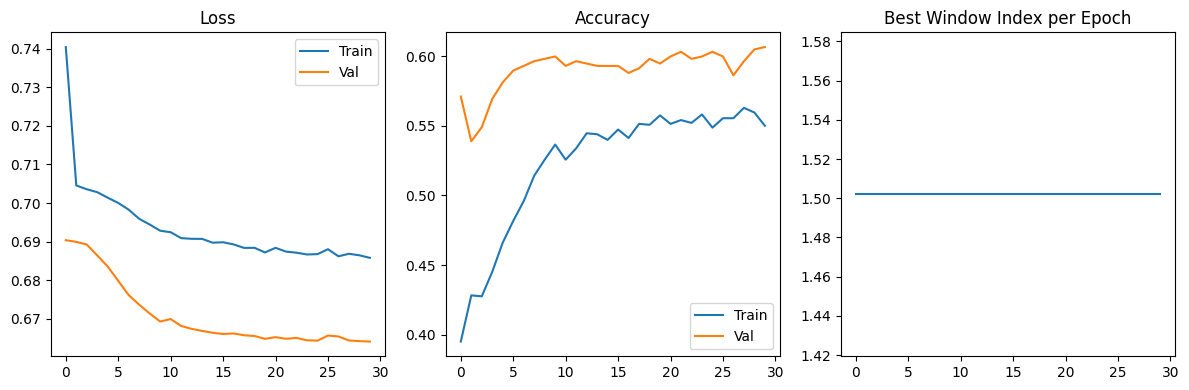

In [7]:

# ============================================================
# 7. Visualizations (Training Dynamics)
# ============================================================

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(best_windows_log)
plt.title("Best Window Index per Epoch")

plt.tight_layout()
plt.show()



In [8]:

# ============================================================
# 8. Evaluate on Test Set
# ============================================================

test_acc = evaluate(model, test_data)
print("TEST ACCURACY:", test_acc)



TEST ACCURACY: 0.6047297297297297


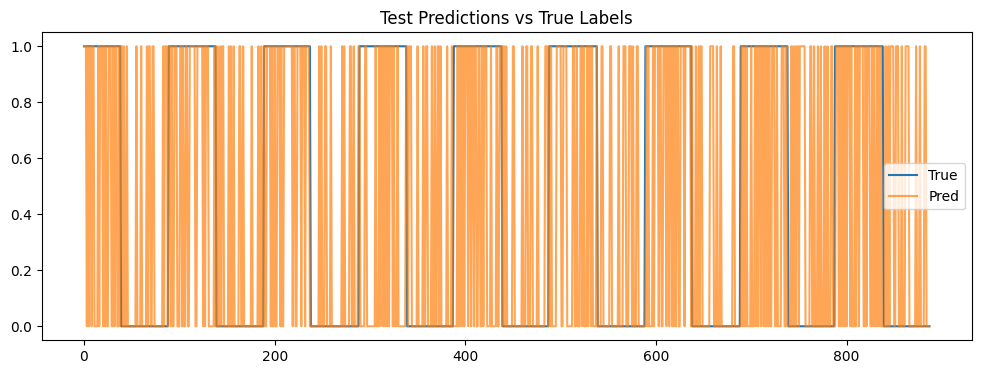

In [9]:

# ============================================================
# 9. Plot Test Predictions vs True
# ============================================================

preds = []
trues = []

model.eval()
with torch.no_grad():
    for x_t, a_t, y_t, _ in test_data:
        logits = model(x_t, a_t)
        preds.append(logits.argmax().item())
        trues.append(y_t.item())

plt.figure(figsize=(12, 4))
plt.plot(trues, label="True")
plt.plot(preds, label="Pred", alpha=0.7)
plt.title("Test Predictions vs True Labels")
plt.legend()
plt.show()



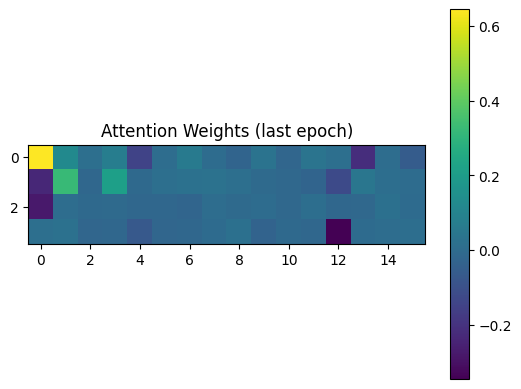

In [10]:

# ============================================================
# 10. Visualize Attention Weights
# ============================================================

if len(model.attention_weights_history) > 0:
    att_sample = model.attention_weights_history[-1].mean(dim=0).numpy()

    plt.imshow(att_sample, cmap="viridis")
    plt.colorbar()
    plt.title("Attention Weights (last epoch)")
    plt.show()
else:
    print("No attention weights recorded.")
